In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
from sklearn.externals.joblib import dump, load

### Data is bitcoin price in a 6 hours' scale

In [0]:
df = pd.read_csv("BTCUSD_6h_2011-09-13_to_2019-10-23_bitstamp.csv")

In [0]:
df.head()

,date,open,high,low,close,volume
0,2011-09-13 12:00:00,5.80,6.00,5.65,5.65,49.895982
1,2011-09-13 18:00:00,5.92,5.97,5.92,5.97,8.475400
2,2011-09-14 00:00:00,NaN,NaN,NaN,NaN,0.000000
3,2011-09-14 06:00:00,5.58,5.72,5.52,5.52,59.108684
4,2011-09-14 12:00:00,5.52,5.53,5.52,5.53,2.037300


#### The start of the couple years, the price was fairly low and from current market condition, we may not see these low prices happen again. To increase the accuracy, these data points were dropped from this analysis

In [ ]:
df_n = df[6000:]

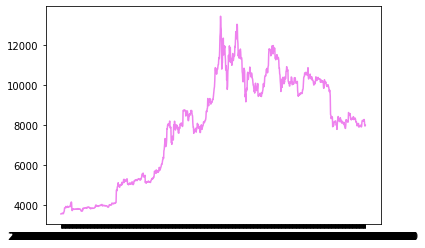

In [0]:
plt.plot(ddd.date, ddd.close, c = "violet")
plt.show()

In [0]:
print(df_n.count())
print(len(df_n))

date      5848
open      5848
high      5848
low       5848
close     5848
volume    5848
dtype: int64
5848


#### Normalize the data as sigmoid is proven to be worked better with normalized data

In [0]:
train_cols = ["open", "close","volume"]
df_train, df_test = train_test_split(df_n, train_size=0.8, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 4678 1170


#### A function to trim the data by the batch size

In [0]:
def trim_d(df, batch_size):
    n = df.shape[0]%batch_size
    if(n > 0):
        return df[:-n]
    else:
        return df

#### Select time step or windows to be 12, i.e. a week

In [0]:
time_step = 12
dim_0 = x_train.shape[0] - time_step
dim_1 = x_train.shape[1]
train_X = np.empty((dim_0, time_step, dim_1))
train_y = np.empty((dim_0,))

for i in range(dim_0):
    train_X[i] = x_train[i:time_step + i]
    train_y[i] = x_train[time_step + i, 1]

train_X = trim_d(train_X, 300)
train_y = trim_d(train_y, 300)

In [0]:
dim_0 = x_test.shape[0] - time_step
dim_1 = x_test.shape[1]
test_X = np.empty((dim_0, time_step, dim_1))
test_y = np.empty((dim_0,))

for i in range(dim_0):
    test_X[i] = x_test[i:time_step + i]
    test_y[i] = x_test[time_step + i, 1]

test_X = trim_d(test_X, 300)
test_y = trim_d(test_y, 300)

#### Established a 4 layers LSTM networks, and using sigmoid function in the output layer. After tuning the hyperparameters, I found RMSprop with a 0.001 learning rate provides the best results, using 20-moving average as the benchmark 

In [0]:
lstm_model = models.Sequential()
lstm_model.add(layers.LSTM(100, batch_input_shape=(300, time_step, train_X.shape[2]),return_sequences = True, dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.LSTM(30,  return_sequences = True))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.LSTM(30, return_sequences = False))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(1,activation='sigmoid'))

optimizer = optimizers.RMSprop(lr=0.001)
#optimizer = optimizers.Adam()
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [0]:
history = lstm_model.fit(train_X, train_y, epochs=200, verbose=1, batch_size=300,shuffle=False, validation_data=(test_X,test_y))

Train on 4500 samples, validate on 900 samples
Epoch 1/200
4500/4500 [==============================] - 2s 453us/step - loss: 4.1422e-04 - val_loss: 2.0581e-04
Epoch 2/200
4500/4500 [==============================] - 2s 413us/step - loss: 3.9416e-04 - val_loss: 3.7168e-04
Epoch 3/200
4500/4500 [==============================] - 2s 405us/step - loss: 6.0814e-04 - val_loss: 2.4383e-04
Epoch 4/200
4500/4500 [==============================] - 2s 402us/step - loss: 3.4830e-04 - val_loss: 2.2333e-04
Epoch 5/200
4500/4500 [==============================] - 2s 399us/step - loss: 5.1289e-04 - val_loss: 2.1779e-04
Epoch 6/200
4500/4500 [==============================] - 2s 401us/step - loss: 3.7621e-04 - val_loss: 2.5293e-04
Epoch 7/200
4500/4500 [==============================] - 2s 401us/step - loss: 4.9871e-04 - val_loss: 1.7935e-04
Epoch 8/200
4500/4500 [==============================] - 2s 406us/step - loss: 3.5773e-04 - val_loss: 1.8872e-04
Epoch 9/200
4500/4500 [==========================

In [0]:
lstm_model.save_weights('lstm_model.h5')

In [0]:
lstm_model.save('my_model.h5')

In [0]:
df_n['SMA'] = df.iloc[:,4].rolling(window=20).mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_n.iloc[127,]

date      2015-11-23 06:00:00
open                   321.83
high                   324.79
low                    320.39
close                   324.7
volume                1194.39
SMA                   326.119
Name: 6127, dtype: object

In [0]:
df_t = df_n.iloc[-1116:,]
df_t['SMA'] = df.iloc[:,4].rolling(window=20).mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
from sklearn.metrics import mean_squared_error

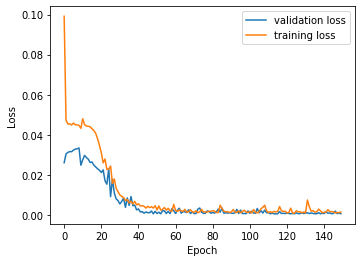

In [0]:
fig = plt.figure(figsize=(12,4))
ax0 = fig.add_subplot(121)
ax0.plot(history.history['val_loss'], label='validation loss')
ax0.plot(history.history['loss'], label='training loss')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')
ax0.legend()

In [0]:
df_test = df_t.drop(columns = ["date", "high", "low", "SMA"])
df_test = min_max_scaler.transform(df_test)
d0 = df_test.shape[0] - time_step
d1 = df_test.shape[1]
test_s = np.empty((d0, time_step, d1))
for i in range(d0):
    test_s[i] = df_test[i:time_step + i]
print(len(test_s))

1104


In [0]:
test = trim_d(test_s, 300)

In [0]:

lst = lstm_model.predict(test, batch_size=300)


In [0]:

#pred = min_max_scaler.inverse_transform(lst)
pred = (lst * min_max_scaler.data_range_[1]) + min_max_scaler.data_min_[1]

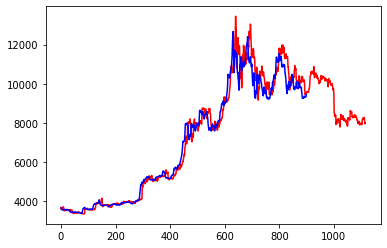

In [0]:
#plt.plot(range(len(df_t.SMA)), df_t.SMA, c = "green")
plt.plot(range(len(df_t.SMA)), df_t.close, c = "red")
plt.plot(range(len(lst)), pred, c = "blue")
plt.show()

In [0]:
t = df_t[-len(test_s):-(len(test_s) - len(lst))]
len(t)

900

#### This nerural network has a 92103 MSE on the test set, outperforming the MA with 168252 SME.

In [0]:
t["pred"] = pred
mean_squared_error(t.close, t.pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


92103.97470556728

In [0]:
mean_squared_error(t.close, t.SMA)

168252.1796985026